# Анализ результатов А/А/В эксперимента внедрения нового шрифта в мобильном приложении

## Информация о проекте

Данные предоставлены от стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах.

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.


## План действий

1. Загрузить данные и подготовить их к анализу.
2. Изучить и проверить данные.
3. Изучить воронку событий. 
6. Изучите результаты эксперимента. 

## Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных

### Импортирование библиотек и вывод данных

In [ ]:
# Импортируем библиотеки:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import stats as st
from scipy.stats import mannwhitneyu
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

# Закрепим формат float:
pd.set_option('display.float_format', '{:,.2f}'.format)

# Уберем предупреждения:
import warnings
warnings.simplefilter('ignore')

# Сброс ограничений на количество выводимых данных:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

### Загрузка данных и подготовка их к анализу

In [ ]:
# Загрузим данные:
try: # мой путь
    df = pd.read_csv('logs_exp.csv', sep='\t')
except: # яндексовский путь
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [ ]:
# Создадим фукнцию для вывода всех необходимых характеристик данных:
def analize(table):
    display(table.head(10))
    display(table.info())
    display(table.describe())
    display('Число пропусков:', table.isnull().sum())
    display('Число дубликатов:', table.duplicated().sum())

In [ ]:
analize(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,DeviceIDHash,EventTimestamp,ExpId
count,"244,126.00","244,126.00","244,126.00"
mean,"4,627,568,124,591,259,648.00","1,564,913,915.84",247.02
std,"2,642,424,998,963,961,856.00","177,134.32",0.82
min,"6,888,746,892,508,752.00","1,564,029,816.00",246.00
25%,"2,372,212,476,992,240,640.00","1,564,756,580.25",246.00
50%,"4,623,191,541,214,045,184.00","1,564,919,395.00",247.00
75%,"6,932,517,045,703,054,336.00","1,565,074,511.00",248.00
max,"9,222,603,179,720,523,776.00","1,565,212,517.00",248.00


'Число пропусков:'

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

'Число дубликатов:'

413

**Вывод:** 
- Названия столбцов не camel case
- Пропусков нет
- Есть 453 дубликата
- Тип данных у EventTimestamp неверный

Проведем предобработку данных. 

In [ ]:
# Заменим названия столбцов на snake case:
df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
             )

df.columns

Index(['event_name', 'device_idhash', 'event_timestamp', 'exp_id'], dtype='object')

In [ ]:
# Удалим дубликаты:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [ ]:
# Добавим столбец даты и времени, а также отдельный столбец дат
df['date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['date_time'].apply(lambda x: x.date())
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_idhash    243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [ ]:
# Выявим сколько групп в ААВ-тесте:
print(df['exp_id'].unique())

[246 248 247]


In [ ]:
# Проверим не попадают ли какие либо пользователи в группы:
df_grouped = df.groupby('device_idhash').agg({'exp_id': 'nunique'})
users_in_multiple_groups = df_grouped.query('exp_id > 1')
users_in_multiple_groups

,exp_id
device_idhash,


**Вывод:** одни и те же пользователи не попали в разные группы

## Изучить и проверить данные

In [ ]:
# Сколько всего событий в логе
print(f'Число событий в логе: {len(df)}')

# Сколько всего пользователей в логе
print(f'Число пользователей в логе: {df["device_idhash"].nunique()}')

# Сколько в среднем событий приходится на пользователя
print(f"Число в среднем событий на пользователя: {round(df.groupby('device_idhash').agg({'event_name':'count'}).mean(), 2)}")

Число событий в логе: 243713
Число пользователей в логе: 7551
Число в среднем событий на пользователя: event_name   32.28
dtype: float64


In [ ]:
# Проверим за какой период есть данные:
print(f"Период, за который есть данные: {df['date'].min(), '-', df['date'].max()}")

Период, за который есть данные: (Timestamp('2019-07-25 00:00:00'), '-', Timestamp('2019-08-07 00:00:00'))


<Axes: >

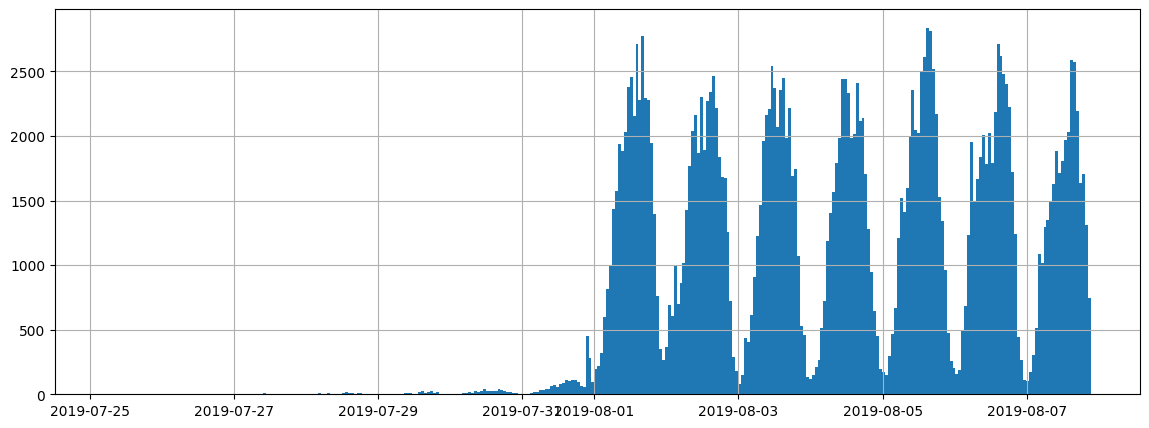

In [ ]:
# Построим гистограмму по дате и времени, чтобы проверить насколько полные данные имеем:
df['date_time'].hist(bins=14*24, figsize=(14, 5))

<Axes: >

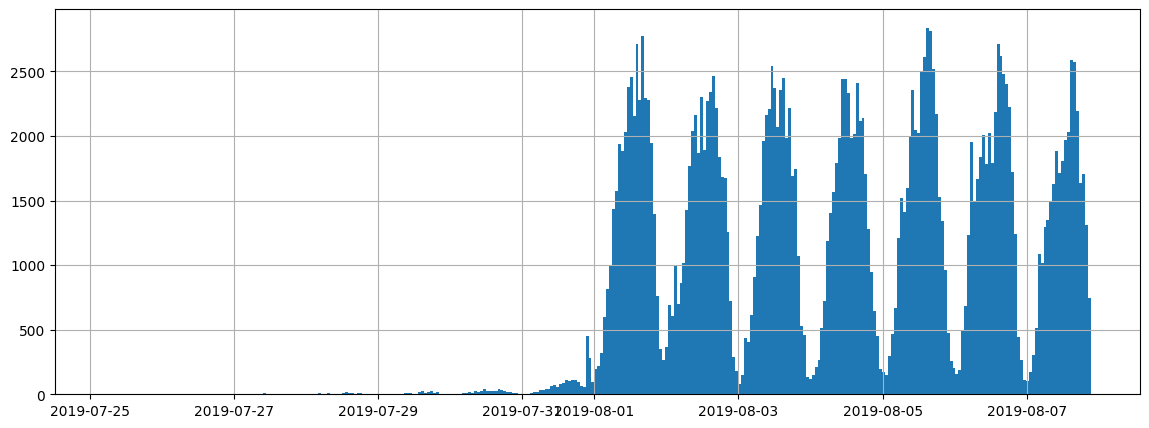

In [ ]:
# код ревьюера
df['date_time'].hist(bins=14*24, figsize=(14, 5))

**Вывод:** Данных до 31 июля 2019 почти нет, основная масса данных за август, поэтому предлагается сделать срез данных и откинуть ненужные. 

<Axes: >

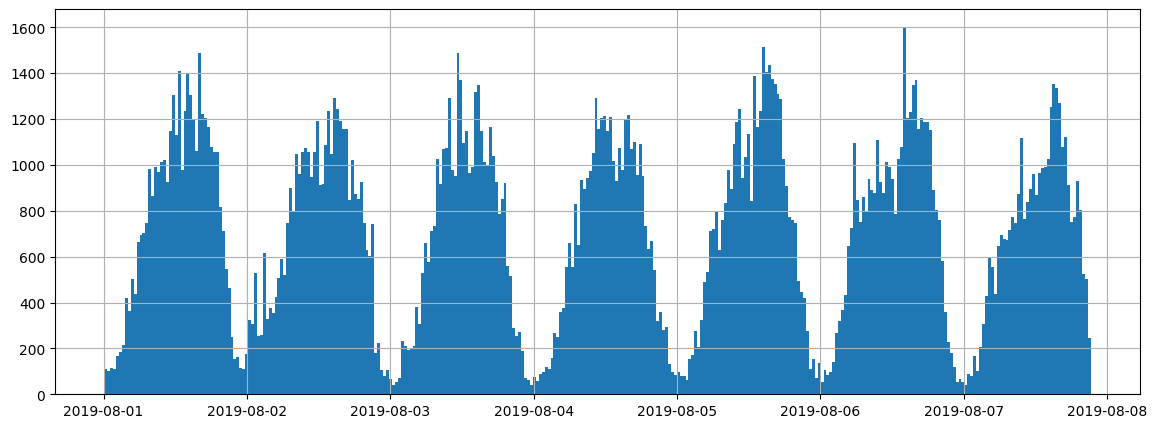

In [ ]:
# Уберем лишние данные:
df_flt = df.query('date > "2019-07-31"')
df_flt['date_time'].hist(bins=14*24, figsize=(14, 5))

In [ ]:
# Много ли событий и пользователей мы потеряли, отбросив старые данные
print(f"Число событий в логе: {df_flt['event_name'].nunique()}, было: {df['event_name'].nunique()}")
print()
print(f"Потеряно событий: {len(df) - len(df_flt)}")
print(f"Доля исключенных событий от всех данных: {(len(df) - len(df_flt))/len(df):.2%}")
print()
print(f"Потеряно пользователей: {df['device_idhash'].nunique() - df_flt['device_idhash'].nunique()}")
print(f"Доля исключенных пользователей от всех данных: {int(df['device_idhash'].nunique()) - int(df_flt['device_idhash'].nunique())/int(df['device_idhash'].nunique()):.2%}")

print()
# Проверим, что у нас есть пользователи из всех трёх экспериментальных групп
print(f"Экспериментальные группы: {df_flt.groupby('exp_id')['event_name'].nunique()}")

Число событий в логе: 5, было: 5

Потеряно событий: 2826
Доля исключенных событий от всех данных: 1.16%

Потеряно пользователей: 17
Доля исключенных пользователей от всех данных: 755000.23%

Экспериментальные группы: exp_id
246    5
247    5
248    5
Name: event_name, dtype: int64


**Вывод:** Практически не изменилось число пользователей после среза, экспериментальные группы есть все три, число событий в группах тоже сохранилось. 

## Изучить воронку событий

In [ ]:
# Посмотрим, какие события есть в логах, как часто они встречаются.
event_counts = df_flt['event_name'].value_counts().reset_index()
event_counts.columns = ['event_name', 'count']

# Отсортируем события по частоте.
event_counts = event_counts.sort_values('count', ascending=False)
event_counts

,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [ ]:
# Посчитаем, сколько пользователей совершали каждое из этих событий
user_counts = df_flt.groupby('event_name')['device_idhash'].nunique().reset_index()
user_counts.columns = ['event_name', 'user_count']

# Исключим tutorial из выборки
user_counts = user_counts[user_counts['event_name'] != 'Tutorial']

# Отсортируем события по числу пользователей
user_counts = user_counts.sort_values('user_count', ascending=False).reset_index(drop=True)

# Посчитаем долю пользователей, которые хоть раз совершали событие
user_counts['conversion'] = round(user_counts['user_count'] / 
                                   df_flt['device_idhash'].nunique()*100, 2)
user_counts

,event_name,user_count,conversion
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


**Вывод:** 
* Скорее всего Tutorial это не обязательный элемент в мобильном приложении, который можно закрыть при первом скачиваниии. Его не будем учитывать. 
* Далее идет следующая цепочка действий: MainScreenAppear - OffersScreenAppear * CartScreenAppear - PaymentScreenSuccessful, т.е. главный экран - экран с предложениями - корзина - экран успешной оплаты.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [ ]:
# Посчитаем число пользователей пользователей проходит на следующий шаг воронки 
user_counts['conversion_per_step'] = round((user_counts['user_count'] / 
                                            user_counts['user_count'].shift(1, 
                                            fill_value=user_counts.loc[0, 
                                                        'user_count']))*100, 2)
user_counts

,event_name,user_count,conversion,conversion_per_step
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


In [ ]:
# Изобразим воронку событий
fig = go.Figure(go.Funnel(y = ['Главный экран', 'Экран со спецпредложениями', 'Корзина', 'Успещная оплата'],
                          x = user_counts['user_count'],
                          textinfo = 'value + percent previous'
                      ))

fig.update_layout(title_text = 'Воронка событий')
fig.show()

**Вывод:** 
- Больше всего теряется пользователей на этапе перехода от главного экрана к экрану со скидками. 
- До оплаты доходят 47% пользователей. 
- Стоит изучить причины того, что 38% клиентов отваливаются при просмотре главного экрана и не совершают дальнейший действий и только 50% доходит до оплаты, причины могут быть различные: 
    * технические, 
    * кривой UI/UX, 
    * реклама привлекла нецелевых клиентов - пользователю показаны неинтересные ему товары, стоимость товаров слишком высокая и прочее. 

## Изучить результаты эксперимента

Посчитаем сколько пользователей в каждой экспериментальной группе. 

In [ ]:
# Сгруппируем данные по экспериментам и вычислим количество пользователей:
exp_counts = df_flt.groupby('exp_id')['device_idhash'].nunique().reset_index()
exp_counts.columns = ['exp_id', 'user_count']

print(exp_counts)
exp_counts.loc[0, 'user_count']

   exp_id  user_count
0     246        2484
1     247        2513
2     248        2537


2484

**Вывод:** Число пользователей в каждой экспериментальной группе практически одинаковое. 

Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп, а также добавим общее число пользователей по каждой группе. 

In [ ]:
# Создадим сводную таблицу, рассчитав количество пользователей по группам и событиям
users_exp = (df_flt[df_flt['event_name'] != 'Tutorial']
                   .pivot_table(index='event_name', columns = 'exp_id', 
                                values = 'device_idhash', aggfunc = 'nunique', 
                                margins=True, margins_name='Total_users')
                   .sort_values(by=246, ascending = False)
                   .reset_index())

users_exp = users_exp.drop('Total_users', axis=1)
users_exp = users_exp.loc[users_exp.index != 0].append(users_exp.loc[0]).reset_index(drop=True)
users_exp

exp_id,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Total_users,2483,2512,2535


In [ ]:
#  добавим столбец с объединенной контрольной группой
users_exp['246+247'] = users_exp[246] + users_exp[247]
users_exp.set_index('event_name', inplace=True)
users_exp

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Total_users,2483,2512,2535,4995


In [ ]:
# Создадим функцию для проверки отличия между группами через z-test
def z_test(group1, group2, event_name, alpha):
    # количество пользователей при событии
    g_users_1 = users_exp.loc[event_name, group1]
    g_users_2 = users_exp.loc[event_name, group2] 
    # общее количество пользователей
    t_users_1 = users_exp.loc['Total_users', group1] 
    t_users_2 = users_exp.loc['Total_users', group2] 
    
    p1 = g_users_1 / t_users_1
    p2 = g_users_2 / t_users_2

    p_combined = (g_users_1 + g_users_2) / (t_users_1 + t_users_2)
    difference = p1 - p2 

    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/t_users_1 + 1/t_users_2))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Событие:', event_name)
    print('p-значение: ', '{0:.2%}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. 

Посчитаем статистическую значимость различий между выборками 246, 247, 246+247 и 248.

Сформулируем гипотезы: 
- Нулевая: доли уникальных посетителей, побывавших на этапе воронки, одинаковы. 
- Альтернативная: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

Значение alpha - 0.05. Предлагается выбрать 0.05, тк несмотря на большие размеры долей выборок, у нас большое количество проверок - 16, что увеличит вероятность ошибки первого рода.

Метод проверки гипотез: Z-тест.

In [ ]:
# сделаем список из событий и прогоним функцию по экпериментам 246 и 247
list = user_counts['event_name'].values.tolist()

for i in list:
  z_test(246, 247, i, 0.05)
  print()

Событие: MainScreenAppear
p-значение:  75.27%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  24.79%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  22.87%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  11.45%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** 
- Статистические критерии не нашли разницу между выборками 246 и 247 по событиям. 
- Разбиение на группы было сделано корректно. Можно быть уверененным в точности проведенного тестирования.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [ ]:
# прогоним функцию по экпериментам 246 и 248
for i in list:
  z_test(246, 248, i, 0.05)
  print()

Событие: MainScreenAppear
p-значение:  33.87%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  21.44%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  8.07%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  21.69%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Статистические критерии не нашли разницу между контрольной выборкой 246 и группой с измененным шрифтом 248. 

In [ ]:
# прогоним функцию по экпериментам 247 и 248
for i in list:
  z_test(247, 248, i, 0.05)
  print()

Событие: MainScreenAppear
p-значение:  51.95%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  93.34%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  58.78%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  72.76%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Статистические критерии не нашли разницу между контрольной выборкой 247 и группой с измененным шрифтом 248. 

In [ ]:
# прогоним функцию по экпериментам 246+247 и 248
for i in list:
  z_test('246+247', 248, i, 0.05)
  print()

Событие: MainScreenAppear
p-значение:  34.87%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  44.58%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  18.68%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  61.08%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** 
- Статистические критерии не нашли разницу между объединенной контрольной выборкой 246+247 и группой с измененным шрифтом 248.
- Было проведено 16 тестов, все тесты не показали статистически значимой разницы между данными.
- При множественном сравнении существует проблема роста ошибки первого рода, при множественной проверке растет риск ложноположительного результата. Однако уменьшение значения альфа здесь не имеет смысла, так как это не изменит результаты.

**Выводы:**
- За основу были взяты данные за август 2019. Данные за июль были отброшены, тк тест был запущен 1-го августа, а предыдущие события - это старые логи, которые "доехали" в выборку.
- Изучение данных и воронки событий выявило, что только 62% пользователей переходят от главного экрана на экран с товаром. Требуется провести дополнительный анализ отказа клиентов от дальнейших действий.
- Событие Tutorial, мы отбросили, тк оно не имеет значимость в воронке событий. 
- До оплаты товара доходит только 50% пользователей, что требует также дополнительного анализа. 
- Оценка контрольных групп 246 и 247 показала, что различий между выборками нет - разбиение на группы было сделано корректно, можно быть уверененным в точности проведенного тестирования.
- Результаты теста говорят, что между контрольными выборками 246 и 247 и выборкой 248 с новым шрифтом нет отличий, соотвественно менеджеры могут быть спокойны в плане изменений. 

**Рекомендации:**
- Провести дополнительный анализ, почему 38% пользователей не переходят с главного экрана на экран с товарами и почему только 50% доходят до оплаты. 